In [1]:
print("Last updated: $(read(`date`, String))")

Last updated: Wed Aug 12 07:45:51 PDT 2020


In [2]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [196]:
# Import Libraries
using Turing
using Turing: Variational
using Distributions
using Distances
using AbstractGPs, KernelFunctions
using PyPlot
using StatsFuns
import Random
using Flux
import LinearAlgebra
using JSON3

In [8]:
# For getting quantiles along array dimensions
function quantiles(X, q; dims, drop=false)
  Q = mapslices(x -> quantile(x, q), X, dims=dims)
  out = drop ? dropdims(Q, dims=dims) : Q
  return out
end

# To extract parameters from ADVI model.
function make_extractor(m, q, nsamples=1000)
    qsamples = rand(q, nsamples)
    _, sym2range = Variational.bijector(m; sym_to_ranges = Val(true));
    return sym -> qsamples[collect(sym2range[sym][1]), :]
end
;

In [90]:
struct ModifiedSqExpKernel{Talpha<:Real, Trho<:Real} <: KernelFunctions.SimpleKernel
    alpha::Talpha
    rho::Trho
end
KernelFunctions.kappa(k::ModifiedSqExpKernel, d2::Real) = k.alpha^2 * exp(-d2/(2*k.rho^2))
KernelFunctions.metric(k::ModifiedSqExpKernel) = SqEuclidean()

In [438]:
@model function GPRegression(y, X, m_alpha=0.0, s_alpha=1.0, m_rho=0.0,
                             s_rho=1.0, m_sigma=0.0, s_sigma=1.0)
    # Priors.
    alpha ~ LogNormal(m_alpha, s_alpha)
    rho ~ LogNormal(m_rho, s_rho)
    sigma ~ LogNormal(m_sigma, s_sigma)
    
    # Realized covariance function
    kernel = ModifiedSqExpKernel(alpha, rho)
    K = kernelmatrix(kernel, X, obsdim=1) + LinearAlgebra.I * sigma^2
    
    # Sampling Distribution.
    y ~ MvNormal(K)  # mean=0, covariance=K.
end;

In [434]:
# Read data.

# Directory where all simulation data are stored.
data_path = joinpath(@__DIR__, "../data/gp-data-N30.json")

# Load data in JSON format.
data = let
    x = open(f -> read(f, String), data_path)
    JSON3.read(x)
end

# Reshape data if needed.
y = Float64.(data[:y])
X = Float64.(reshape(data[:x], length(y), 1))

f = Float64.(data[:f])
x_grid = Float64.(data[:x_grid])

N = size(X, 1);

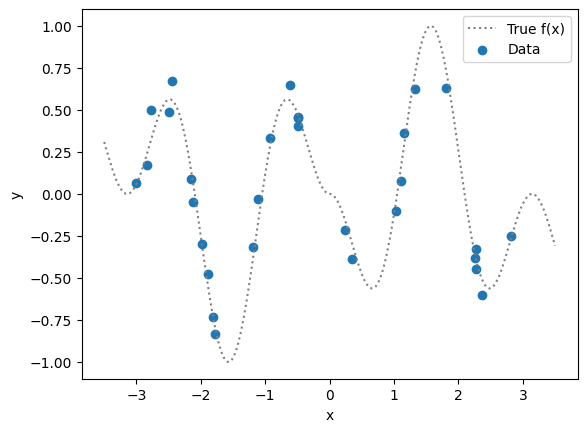

In [435]:
# Plot data
plt.scatter(vec(X), y, label="Data")
plt.plot(x_grid, f, c="grey", ls=":", label="True f(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

In [439]:
# Create model.
m = begin
    m_alpha = 0.0
    s_alpha = 0.1
    m_rho = 0.0
    s_rho = 1.0
    m_sigma = 0.0
    s_sigma = 1.0
    GPRegression(y, X, m_alpha, s_alpha, m_rho, s_rho, m_sigma, s_sigma)
end;

In [440]:
# Fit via ADVI.
Random.seed!(0)

# initialize variational distribution (optional)
q0 = Variational.meanfield(m)

# NOTE: ADVI(num_elbo_samples, max_iters)

# Compile
@time q = vi(m, ADVI(1, 1), q0, optimizer=Flux.ADAM(1e-1));

# RUN
@time q = vi(m, ADVI(1, 2000), q0, optimizer=Flux.ADAM(1e-1));

# Get posterior samples
extract_gp = make_extractor(m, q)
alpha = vec(extract_gp(:alpha));
rho = vec(extract_gp(:rho));
sigma = vec(extract_gp(:sigma));
advi_samples = Dict(:alpha => alpha, :rho => rho, :sigma => sigma);

LinearAlgebra.PosDefException: PosDefException: matrix is not positive definite; Cholesky factorization failed.

In [299]:
# Fit via HMC.
Random.seed!(0)
burn = 1000
nsamples = 1000

# Compile
@time _ = sample(m, HMC(0.01, 1), 1)

# Run
@time chain = sample(m, HMC(0.01, 100), burn + nsamples)

# Get posterior samples
alpha = vec(group(chain, :alpha).value.data[end-nsamples:end, :, 1]);
rho = vec(group(chain, :rho).value.data[end-nsamples:end, :, 1]);
sigma = vec(group(chain, :sigma).value.data[end-nsamples:end, :, 1]);
hmc_samples = Dict(:alpha => alpha, :rho => rho, :sigma => sigma);

  3.600857 seconds (8.62 M allocations: 428.936 MiB, 3.61% gc time)


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:16


 16.504091 seconds (11.53 M allocations: 24.138 GiB, 12.84% gc time)


In [300]:
# Fit via NUTS.
Random.seed!(7)

# Compile
@time _ = sample(m, NUTS(4, 0.8), 9);

# Run
@time chain = begin
    nsamples = 1000  # number of MCMC samples
    nadapt = 1000  # number of iterations to adapt tuning parameters in NUTS
    iterations = nsamples + nadapt
    target_accept_ratio = 0.8
    
    sample(m, NUTS(nadapt, target_accept_ratio, max_depth=10), iterations);
end

# Get posterior samples
alpha = vec(group(chain, :alpha).value.data[:, :, 1]);
rho = vec(group(chain, :rho).value.data[:, :, 1]);
sigma = vec(group(chain, :sigma).value.data[:, :, 1]);
nuts_samples = Dict(:alpha => alpha, :rho => rho, :sigma => sigma);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/ubuntu/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629


  3.890037 seconds (8.98 M allocations: 467.777 MiB, 3.62% gc time)


┌ Info: Found initial step size
│   ϵ = 0.20625000000000002
└ @ Turing.Inference /home/ubuntu/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.288148 seconds (1.64 M allocations: 1.617 GiB, 14.68% gc time)


In [301]:
# Function for plotting parameter posterior.
function plot_post(samples, name; bins=nothing, suffix="")
    param = samples[name]
    plt.hist(param, density=true, bins=bins)
    plt.xlabel(name)
    plt.ylabel("density")
    if suffix !== ""
        suffix = "($(suffix))"
    end
    plt.title("Histogram of $(name) $(suffix)");
end

plot_post (generic function with 1 method)

In [345]:
function plot_fn_posterior(samples; figsize=(12, 4), figsize_f=figsize, suffix="")
    # Get parameters
    alpha = samples[:alpha]
    rho = samples[:rho]
    sigma = samples[:sigma]
    nsamps = length(alpha)
   
    # Plot parameters posterior.
    plt.figure(figsize=figsize)
    plt.subplot(1, 3, 1)
    plot_post(samples, :alpha, bins=30, suffix=suffix)
    plt.subplot(1, 3, 2)
    plot_post(samples, :rho, bins=30, suffix=suffix)
    plt.subplot(1, 3, 3)
    plot_post(samples, :sigma, bins=30, suffix=suffix)    
    plt.axvline(data[:sigma], ls=":", label="truth", color="red")
    plt.legend()
    plt.tight_layout()
    
    # Make predictions at new locations.
    # Uses AbstractGPs: GP, posterior.
    X_new = reshape(collect(range(-3.5, 3.5, length=100)), 100, 1)
    ynew = [let
        kernel = ModifiedSqExpKernel(alpha[i], rho[i])
        kernel += 1e-12 * EyeKernel()  # for numerical stability.
        f = GP(kernel)
        pfx = posterior(f(X[:,1], sigma[i]^2), y)
        rand(pfx(X_new[:,1])) + randn(length(X_new)) * sigma[i]
    end for i in 1:nsamps];
    ynew = hcat(ynew...)
    
    # Summary statistics of posterior function.
    pred_mean = mean(ynew, dims=2)
    pred_lower = quantiles(ynew, 0.025, dims=2)
    pred_upper = quantiles(ynew, 0.975, dims=2)
    
    if suffix !== ""
        suffix = "($(suffix))"
    end 
     
    # Plot predictions.
    plt.figure(figsize=figsize_f)
    plt.plot(vec(X_new), vec(pred_mean), color="blue", label="Posterior predictive mean")
    plt.plot(x_grid, f, color="red", ls=":", label="True f(x)")
    
    plt.scatter(vec(X), vec(y), color="black", label="Data")
    plt.fill_between(vec(X_new), vec(pred_upper), vec(pred_lower), color="blue",
                     alpha=0.2, label="95% Credible Interval")
    plt.legend(loc="upper left", fontsize=8)
    plt.title("GP Posterior predictive with 95% credible interval $(suffix)");
    
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.ylim(-2, 2)
    plt.tight_layout()
end

plot_fn_posterior (generic function with 1 method)

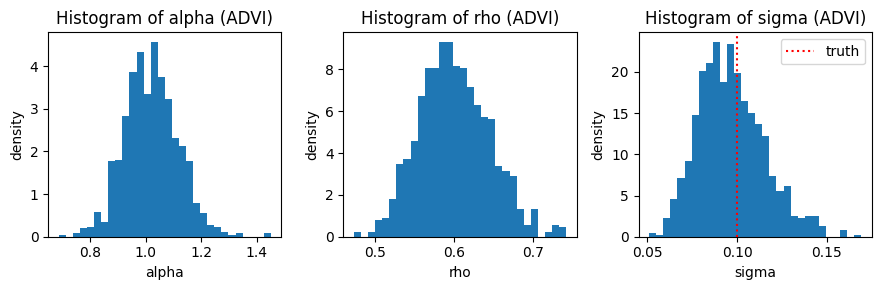

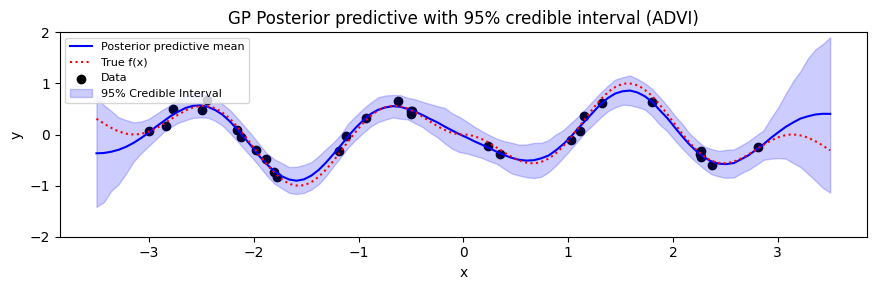

In [432]:
plot_fn_posterior(advi_samples, figsize=(9, 3), suffix="ADVI")

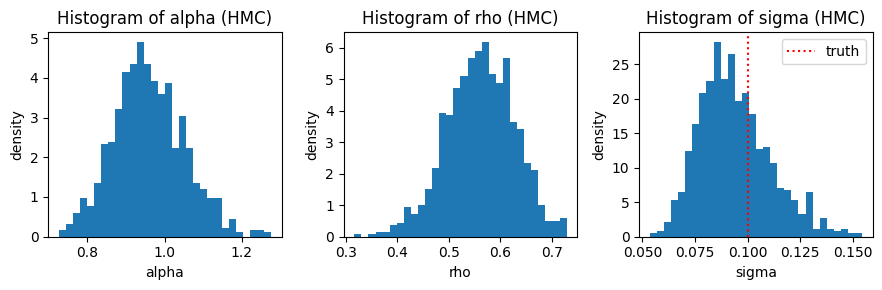

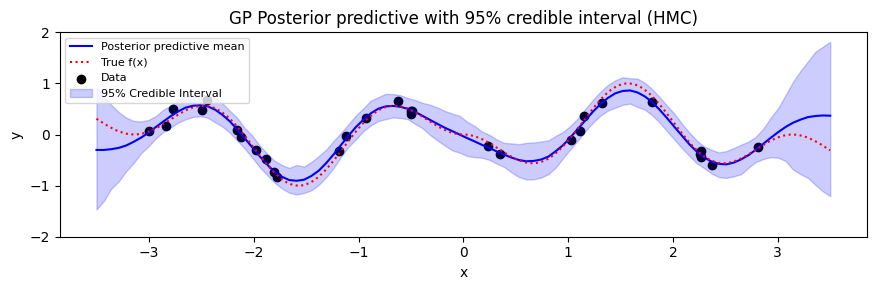

In [347]:
plot_fn_posterior(hmc_samples, figsize=(9, 3), suffix="HMC");

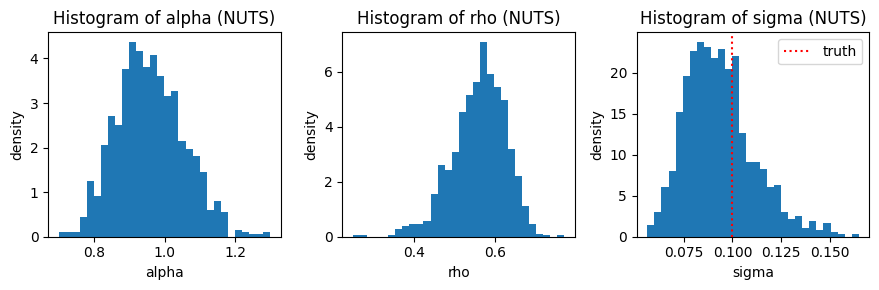

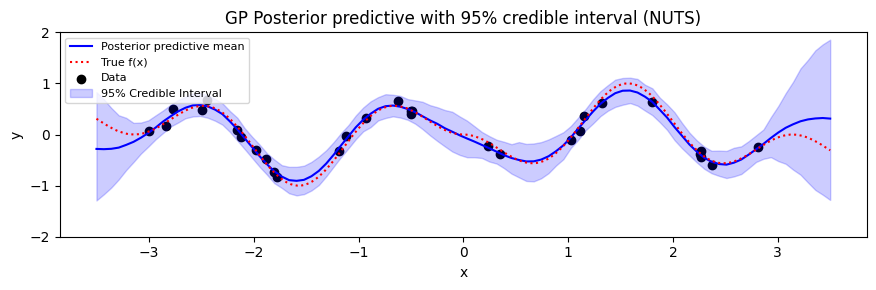

In [348]:
plot_fn_posterior(nuts_samples, figsize=(9, 3), suffix="NUTS");